In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [19]:
class z24Dataset(Dataset):
    def __init__(self, mode='training', window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.mode = mode
        
        if mode == 'training':
            self.index_file = np.loadtxt('../tools/training_set_index.txt',dtype=str)
        elif mode == 'testing' :
            self.index_file = np.loadtxt('../tools/test_set_index.txt',dtype=str)
        elif mode == 'validating':
            self.index_file = np.loadtxt('../tools/validation_set_index.txt',dtype=str)

        
        self.name_index_dict = dict(zip(range(len(self.index_file)),list(self.index_file)))
        
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return len(self.index_file) * self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        file_to_read = self.name_index_dict[index_to_read]
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size

        file_path_vib = '../data/z24_clean/'+file_to_read+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+file_to_read+'_env.npy'
        
        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()

In [20]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, z_size, output_size, dropout_p):
        super(Model, self).__init__()
        self.dropout_p = dropout_p

        self.h1 = nn.Linear(input_size, hidden_size)
        self.z  = nn.Linear(hidden_size, z_size)
        self.h2 = nn.Linear(z_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.relu(self.h1(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.relu(self.z(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.relu(self.h2(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.h3(x)
        return x

In [21]:
class Initializer:
    # to apply xavier_uniform:
    #Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
    # or maybe normal distribution:
    #Initializer.initialize(model=net, initialization=init.normal_, mean=0, std=0.2)
    def __init__(self):
        pass

    @staticmethod
    def initialize(model, initialization, **kwargs):
        def weights_init(m):
            if isinstance(m, nn.Linear):
                initialization(m.weight.data, **kwargs)
                try:
                    initialization(m.bias.data)
                except:
                    pass
        model.apply(weights_init)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


n_epochs = 50
batch_size = 500
window_size = 100

In [23]:
#Datasets
training_dataset = z24Dataset(mode='training', window_size=window_size, normalize=True)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

validating_dataset = z24Dataset(mode='validating', window_size=window_size, normalize=True)
validating_dataloader = DataLoader(validating_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [24]:
#hyperparameters
hyperspace = {
'dropout_p': 0.1,
'learning_rate': 0.0001,
'weight_init': init.orthogonal_, #init.kaiming_uniform_,
'hidden_size1': 512,
'hidden_size2': 256,
'z_size': 128}

In [25]:
#define model
model = Model(input_size=7*window_size+53,
              output_size=7*window_size,
              hidden_size=hyperspace['hidden_size2'],
              z_size=hyperspace['z_size'],
              dropout_p=hyperspace['dropout_p']).to(device)

In [26]:
Initializer.initialize(model=model, initialization=hyperspace['weight_init'])

In [27]:
optimizer = torch.optim.Adam(model.parameters(),
                            lr=hyperspace['learning_rate'],
                            betas=(0.9, 0.99),
                            eps=1e-08,
                            weight_decay=0,
                            amsgrad=True)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [int(n_epochs*0.7)], gamma=0.1)

In [28]:
loss_criterion = torch.nn.MSELoss()


In [29]:
#training
train_loss = []
val_loss   = []
for epoch in range(n_epochs):
    batchloss_train = []
    
    for X_train, Y_train in training_dataloader:
        X_train_tensor = X_train.float().to(device)
        Y_train_tensor = Y_train.float().to(device)

        optimizer.zero_grad()  # zero the gradient buffer
        predicted_Y = model(X_train_tensor)
        trainloss = loss_criterion(predicted_Y, Y_train_tensor)
        trainloss.backward()
        optimizer.step()
    
        batchloss_train.append(trainloss.item())
        
    scheduler.step()
    train_loss.append(np.mean(batchloss_train))
    
    batchloss_val = []
    with torch.no_grad():
        for X_val, Y_val in validating_dataloader:
            X_val_tensor = X_val.float().to(device)
            Y_val_tensor = Y_val.float().to(device)
            predicted_Y = model(X_val_tensor)
            valloss = loss_criterion(predicted_Y, Y_val_tensor)
            batchloss_val.append(valloss.item())
        
    val_loss.append(np.mean(batchloss_val))
    
    print('Epoch: {}'.format(epoch))
    print('train loss: {}'.format(np.mean(batchloss_train)))
    print('valiation loss: {}'.format(np.mean(batchloss_val)))

Epoch: 0
train loss: 1.4119794324824684
valiation loss: 0.7747297102496737
Epoch: 1
train loss: 0.9842040708190516
valiation loss: 0.719468088909274
Epoch: 2
train loss: 0.9330496229623494
valiation loss: 0.6978719269945508
Epoch: 3
train loss: 0.8973623558094627
valiation loss: 0.6792783325626737
Epoch: 4
train loss: 0.8614446505119926
valiation loss: 0.6581045208232743
Epoch: 5
train loss: 0.826542278653697
valiation loss: 0.6345837829368455
Epoch: 6
train loss: 0.7888417441593973
valiation loss: 0.6100476822328
Epoch: 7
train loss: 0.7593293411167045
valiation loss: 0.5899911767670086
Epoch: 8
train loss: 0.7322370637404291
valiation loss: 0.5707277105677695
Epoch: 9
train loss: 0.7034694292043385
valiation loss: 0.5524192043535766
Epoch: 10
train loss: 0.6768575307570006
valiation loss: 0.5372927264266071
Epoch: 11
train loss: 0.6587704526750665
valiation loss: 0.5203191432214919
Epoch: 12
train loss: 0.6358870893716813
valiation loss: 0.5084682222278345
Epoch: 13
train loss: 0.623

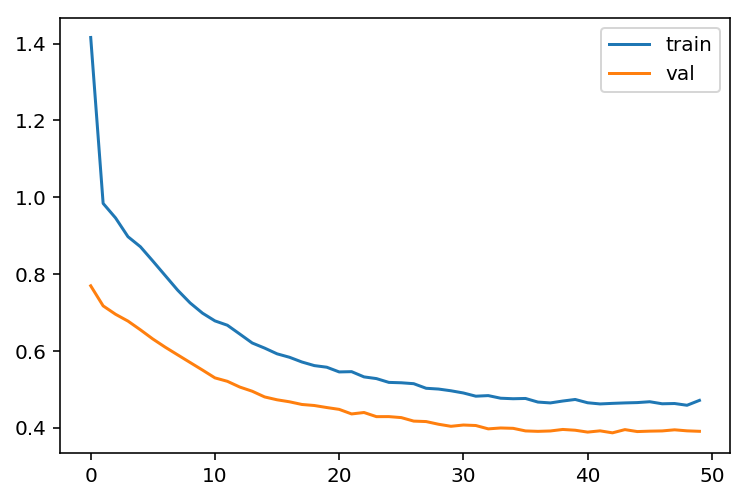

In [17]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()